In [27]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

import os

In [28]:
files = [file for r,d,f in os.walk('/Users/tommasaso/Documents/AI/SpeakerRecognition/DataSet.nosync/train-other-500/') for file in f]
files.remove('.DS_Store')
files = list(filter(lambda s: s.endswith('.flac'), files))
df = pd.DataFrame(files, columns=["files"])
speaker = []
subfolder = []
for i in range(0, len(files)):
    speaker.append(df['files'][i].split('-')[0])
    subfolder.append(df['files'][i].split('-')[1])
df['speaker'] = speaker
df['subfolder'] = subfolder
df.head()

,files,speaker,subfolder
0,797-127183-0031.flac,797,127183
1,797-127183-0027.flac,797,127183
2,797-127183-0007.flac,797,127183
3,797-127183-0050.flac,797,127183
4,797-127183-0046.flac,797,127183


In [29]:
data = pd.read_fwf('/Users/tommasaso/Documents/AI/SpeakerRecognition/DataSet.nosync/SPEAKERS.TXT', delimiter="|", header=None, dtype=None, encoding='utf-8', index=False, comment=';', names=['speaker','gender','dataset','time','speaker_name'])
data[['speaker']] = data[['speaker']].applymap(np.int64)
def fn(row):
    global data 
    return data[(data['speaker'] == int(row['speaker'])) & (data.dataset.str.contains('train-other-500',case=False))].speaker_name.values[0]

df['speaker_name'] = df.apply(fn, axis=1)

In [30]:
#df_reduced = df.sample(frac=0.05, replace=True, random_state=1)
df = shuffle(df)
speakers = df['speaker'].unique()
speakers = speakers[:round(df['speaker'].nunique()/20)]
#if not('0' in speakers):
#    speakers = np.append(speakers, '0')
if not('1' in speakers):
    speakers = np.append(speakers, '1')
df_reduced=df[df['speaker'].isin(speakers)]

# Checking the number of speakers or the number of different people in our voice data
print("Number of sample: "+str(len(df)))
print("Number of sample reduced: "+str(len(df_reduced)))
print("Number of speaker: " + str(df['speaker'].nunique()))
print("Number of speaker reduced: " + str(df_reduced['speaker'].nunique()))

df_reduced = df_reduced.copy()
df_reduced['speaker'] = df_reduced['speaker'].astype(int)
sample = 0

Number of sample: 148764
Number of sample reduced: 7775
Number of speaker: 1168
Number of speaker reduced: 59


In [22]:
def extract_features(files):
    
    global sample
    sample = sample+1
    print("Sample: "+str(sample))
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('DataSet.nosync/train-other-500')+'/'+str(files.speaker)+'/'+str(files.subfolder)+'/'+str(files.files))

    # Loads the audio file as a floating point time series - default sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    
    X, index = librosa.effects.trim(y=X, top_db=40)

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)

    return mfccs, chroma, mel, contrast, tonnetz

In [ ]:
features_label = df_reduced.apply(extract_features, axis=1)

In [ ]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 
features = []

for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label.iloc[i][0], features_label.iloc[i][1], 
                features_label.iloc[i][2], features_label.iloc[i][3],
                features_label.iloc[i][4]), axis=0))
#print(features)

In [ ]:
features_data = np.array(features)
for i in range(0,len(features[0])):
    df_reduced['feature_'+str(i)] = features_data[:,i]

In [12]:
import pickle 
#f = open('dataframe.pkl', 'wb') 
#pickle.dump(df_reduced, f)
f = open('dataframe.pkl', 'rb') 
df_reduced = pickle.load(f)

In [13]:
features_cols = [col for col in df_reduced if col.startswith('feature')]
X = df_reduced[features_cols].to_numpy()
y = df_reduced['speaker_name'].to_numpy()
lb = LabelEncoder()
y_dec = lb.fit_transform(y)
f_encoder = open('LabelEncoder.pkl', 'wb') 
pickle.dump(lb, f_encoder)

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y_dec, test_size=0.3, shuffle=False)

X_test = X_test_val[int(len(X_test_val)*0.5):len(X_test_val)]
X_val = X_test_val[0:int(len(X_test_val)*0.5)]
y_test = y_test_val[int(len(y_test_val)*0.5):len(y_test_val)]
y_val = y_test_val[0:int(len(y_test_val)*0.5)]

In [14]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)
f_scaler = open('StandardScaler.pkl', 'wb') 
pickle.dump(ss, f_scaler)

In [15]:
model = Sequential()

model.add(Dense(len(features_cols), input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(len(speakers), activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [16]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 100 because we did not want to use early stop
# I leave the early stop regularization code in case anyone wants to use it

history = model.fit(X_train, to_categorical(y_train), batch_size=256, epochs=100, 
                    validation_data=(X_val,to_categorical(y_val)),
                    callbacks=[early_stop])                                

Train on 5680 samples, validate on 1217 samples
Epoch 1/100
5680/5680 [==============================] - 1s 243us/sample - loss: 3.8532 - accuracy: 0.0989 - val_loss: 3.1756 - val_accuracy: 0.4495
Epoch 2/100
5680/5680 [==============================] - 0s 53us/sample - loss: 2.8527 - accuracy: 0.3062 - val_loss: 1.7067 - val_accuracy: 0.7313
Epoch 3/100
5680/5680 [==============================] - 0s 53us/sample - loss: 1.8898 - accuracy: 0.5100 - val_loss: 0.8113 - val_accuracy: 0.8907
Epoch 4/100
5680/5680 [==============================] - 0s 52us/sample - loss: 1.2653 - accuracy: 0.6567 - val_loss: 0.4367 - val_accuracy: 0.9351
Epoch 5/100
5680/5680 [==============================] - 0s 52us/sample - loss: 0.8644 - accuracy: 0.7609 - val_loss: 0.2573 - val_accuracy: 0.9556
Epoch 6/100
5680/5680 [==============================] - 0s 52us/sample - loss: 0.6393 - accuracy: 0.8202 - val_loss: 0.1679 - val_accuracy: 0.9770
Epoch 7/100
5680/5680 [==============================] - 0s 52u

Epoch 56/100
5680/5680 [==============================] - 0s 57us/sample - loss: 0.0250 - accuracy: 0.9917 - val_loss: 0.0072 - val_accuracy: 0.9984
Epoch 57/100
5680/5680 [==============================] - 0s 59us/sample - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.0066 - val_accuracy: 0.9992
Epoch 58/100
5680/5680 [==============================] - 0s 61us/sample - loss: 0.0185 - accuracy: 0.9954 - val_loss: 0.0053 - val_accuracy: 0.9975
Epoch 59/100
5680/5680 [==============================] - 0s 62us/sample - loss: 0.0216 - accuracy: 0.9945 - val_loss: 0.0053 - val_accuracy: 0.9975
Epoch 60/100
5680/5680 [==============================] - 0s 60us/sample - loss: 0.0203 - accuracy: 0.9944 - val_loss: 0.0040 - val_accuracy: 0.9984
Epoch 61/100
5680/5680 [==============================] - 0s 64us/sample - loss: 0.0222 - accuracy: 0.9937 - val_loss: 0.0017 - val_accuracy: 0.9992
Epoch 62/100
5680/5680 [==============================] - 0s 59us/sample - loss: 0.0229 - accuracy: 0.9935

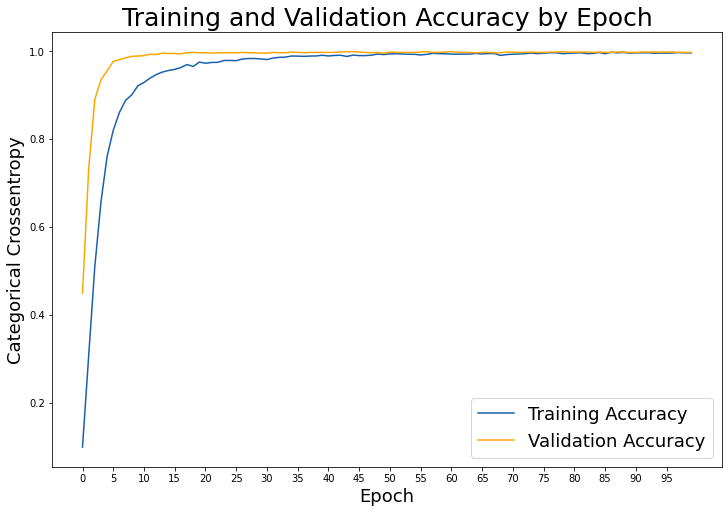

In [17]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

Model Accuracy: 0.9975369458128078
MSE: 3.339080459770115


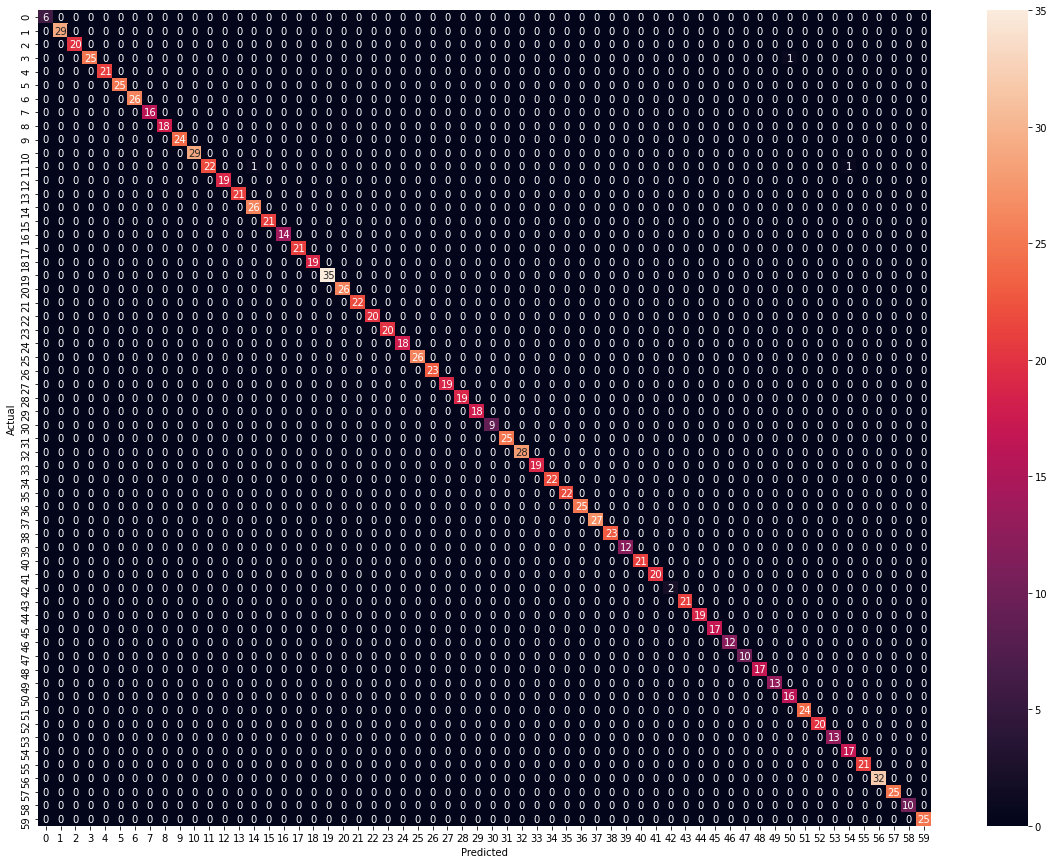

In [18]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import seaborn as sn
y_pred = model.predict_classes(X_test)

print("Model Accuracy: "+str(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)))
print("MSE: "+str(mean_squared_error(y_test, y_pred)))

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(20,15))
sn.heatmap(confusion_matrix, annot=True)

In [26]:
import tensorflow as tf
model = tf.keras.models.load_model('saved_model/my_model')

data = {"files": "1-13-0020.flac", "speaker": "1", 'subfolder': "13"}
test = pd.DataFrame(data = data, index=[0])
features_label_test = test.apply(extract_features, axis=1)
features_test = []
features_test.append(np.concatenate((features_label_test.iloc[0][0], features_label_test.iloc[0][1], 
                features_label_test.iloc[0][2], features_label_test.iloc[0][3],
                features_label_test.iloc[0][4]), axis=0))
test = np.array(features_test)
#print(test)
test = ss.transform(test)
#test_pred= model.predict_proba(test)
test_pred= model.predict_classes(test)
print(lb.inverse_transform(test_pred))
#print(test_pred)

Sample: 4
[' Tommaso Elia']


In [19]:
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
print(df_reduced[df_reduced['speaker_name'])
print(type(list(df_reduced['speaker_name'].unique())))

In [20]:
print(lb.inverse_transform([46]))
print(lb.transform([' Tommaso Elia']))

[' Tommaso Elia']
[46]


In [ ]:
print(speakers)
if not('0' in speakers):
    speakers = np.append(speakers, '0')
print(speakers)

In [ ]:
df_reduced['speaker_name'].unique()